Source: https://github.com/thushv89/attention_keras/blob/master/src/examples/nmt/train.py

In [24]:
from tensorflow import keras
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Input, GRU, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow.python.keras.models import Model
# from layers.attention import AttentionLayer
from tensorflow.python.keras.layers import Layer, Attention, AdditiveAttention
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from  tensorflow.python.keras.layers.dense_attention import BaseDenseAttention

# Load the data


In [2]:
small_vocab_en_url = "https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_en"
small_vocab_en = keras.utils.get_file("small_vocab_en", small_vocab_en_url)

small_vocab_fr_url = "https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_fr"
small_vocab_fr = keras.utils.get_file("small_vocab_fr", small_vocab_fr_url)


# Preprocess the data


In [3]:
def read_data(filename):
    """ Reading the zip file to extract text """
    text = []
    with open(filename, 'r', encoding='utf-8') as f:
        i = 0
        for row in f:
            text.append(row)
            i += 1
    return text

def get_data(train_size, random_seed=100):

    """ Getting randomly shuffled training / testing data """
    en_text = read_data(small_vocab_en)
    fr_text = read_data(small_vocab_fr)

    fr_text = ['sos ' + sent[:-1] + 'eos .'  if sent.endswith('.') else 'sos ' + sent + ' eos .' for sent in fr_text]

    np.random.seed(random_seed)
    inds = np.arange(len(en_text))
    np.random.shuffle(inds)

    train_inds = inds[:train_size]
    test_inds = inds[train_size:]
    tr_en_text = [en_text[ti] for ti in train_inds]
    tr_fr_text = [fr_text[ti] for ti in train_inds]

    ts_en_text = [en_text[ti] for ti in test_inds]
    ts_fr_text = [fr_text[ti] for ti in test_inds]

    return tr_en_text, tr_fr_text, ts_en_text, ts_fr_text

def sents2sequences(tokenizer, sentences, reverse=False, pad_length=None, padding_type='post'):
    encoded_text = tokenizer.texts_to_sequences(sentences)
    preproc_text = pad_sequences(encoded_text, padding=padding_type, maxlen=pad_length)
    if reverse:
        preproc_text = np.flip(preproc_text, axis=1)

    return preproc_text

def preprocess_data(en_tokenizer, fr_tokenizer, en_text, fr_text, en_timesteps, fr_timesteps):
    """ Preprocessing data and getting a sequence of word indices """
    en_seq = sents2sequences(en_tokenizer, en_text, reverse=False, padding_type='pre', pad_length=en_timesteps)
    fr_seq = sents2sequences(fr_tokenizer, fr_text, pad_length=fr_timesteps)
    return en_seq, fr_seq




In [4]:
tr_en_text, tr_fr_text, ts_en_text, ts_fr_text = get_data(train_size=100000)

""" Defining tokenizers """
en_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
en_tokenizer.fit_on_texts(tr_en_text)

fr_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
fr_tokenizer.fit_on_texts(tr_fr_text)

en_vsize = max(en_tokenizer.index_word.keys()) + 1
fr_vsize = max(fr_tokenizer.index_word.keys()) + 1

""" Getting preprocessed data """
en_timesteps, fr_timesteps = 20, 15

tr_en_seq, tr_fr_seq = preprocess_data(en_tokenizer, fr_tokenizer, tr_en_text, tr_fr_text, en_timesteps, fr_timesteps)
tr_en_onehot_seq = to_categorical(tr_en_seq, num_classes=en_vsize)
tr_fr_onehot_seq = to_categorical(tr_fr_seq, num_classes=fr_vsize)



ts_en_seq, ts_fr_seq = preprocess_data(en_tokenizer, fr_tokenizer, ts_en_text, ts_fr_text, en_timesteps, fr_timesteps)
ts_en_onehot_seq = to_categorical(ts_en_seq, num_classes=en_vsize)
ts_fr_onehot_seq = to_categorical(ts_fr_seq, num_classes=fr_vsize)


en_index2word = dict(zip(en_tokenizer.word_index.values(), en_tokenizer.word_index.keys()))
fr_index2word = dict(zip(fr_tokenizer.word_index.values(), fr_tokenizer.word_index.keys()))

# Model

In [34]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]
    


class Attention(BaseDenseAttention):
    def __init__(self, use_scale=False, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.use_scale = use_scale
        
    def build(self, input_shape):
        """Creates scale variable if use_scale==True."""
        if self.use_scale:
            self.scale = self.add_weight(
                name='scale',
                shape=(),
                initializer=tf.compat.v1.ones_initializer(),
                dtype=self.dtype,
                trainable=True)
        else:
            self.scale = None
        super(Attention, self).build(input_shape)
        
    def _calculate_scores(self, query, key):
        """Calculates attention scores as a query-key dot product.
        
        Args:
            query: Query tensor of shape `[batch_size, Tq, dim]`.
            key: Key tensor of shape `[batch_size, Tv, dim]`.
        Returns:
            Tensor of shape `[batch_size, Tq, Tv]`.
        """
        scores = tf.matmul(query, key, transpose_b=True)
        if self.scale is not None:
            scores *= self.scale
        return scores
    
    def get_config(self):
        config = {'use_scale': self.use_scale}
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [41]:
def define_nmt(hidden_size, en_vsize, fr_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.   
    encoder_inputs = Input(shape=(None, en_vsize), name='encoder_inputs')
    decoder_inputs = Input(shape=(None, fr_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # Attention layer
#     attn_layer = Attention(name='attention_layer') # Keras     
    attn_layer = AttentionLayer(name='attention_layer') # Custome Attention
    attn_out, attn_states = attn_layer([encoder_out, decoder_out], verbose=False)

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(fr_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer=optimizers.RMSprop(lr=0.01),
                       loss='CategoricalCrossentropy',
                       metrics=['accuracy'])

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, fr_vsize), name='decoder_word_inputs')
    encoder_inf_states = Input(batch_shape=(batch_size, en_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

    return full_model, encoder_model, decoder_model 

# Training

In [42]:
""" Defining the full model """
full_model, infer_enc_model, infer_dec_model = define_nmt(hidden_size=64, en_vsize=en_vsize, fr_vsize=fr_vsize)


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 201)]  0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 345)]  0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, None, 64), ( 51072       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, None, 64), ( 78720       decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]         

In [43]:
history = full_model.fit(
    [tr_en_onehot_seq, tr_fr_onehot_seq[:, :-1, :]], 
    tr_fr_onehot_seq[:, 1:, :],
    epochs=15,  
    verbose=1,
    batch_size=5120,
    validation_data=([ts_en_onehot_seq, ts_fr_onehot_seq[:, :-1, :]],ts_fr_onehot_seq[:, 1:, :])
)

Epoch 1/15
20/20 [==============================] - 10s 310ms/step - loss: 4.4989 - accuracy: 0.1516 - val_loss: 2.2403 - val_accuracy: 0.4283
Epoch 2/15
20/20 [==============================] - 4s 219ms/step - loss: 1.9573 - accuracy: 0.4809 - val_loss: 1.4690 - val_accuracy: 0.5447
Epoch 3/15
20/20 [==============================] - 4s 219ms/step - loss: 1.3993 - accuracy: 0.5730 - val_loss: 1.0575 - val_accuracy: 0.6693
Epoch 4/15
20/20 [==============================] - 4s 220ms/step - loss: 0.9854 - accuracy: 0.6938 - val_loss: 0.7562 - val_accuracy: 0.7691
Epoch 5/15
20/20 [==============================] - 4s 222ms/step - loss: 0.6385 - accuracy: 0.8052 - val_loss: 0.3896 - val_accuracy: 0.8850
Epoch 6/15
20/20 [==============================] - 4s 221ms/step - loss: 0.3788 - accuracy: 0.8914 - val_loss: 0.2302 - val_accuracy: 0.9379
Epoch 7/15
20/20 [==============================] - 4s 219ms/step - loss: 0.1992 - accuracy: 0.9484 - val_loss: 0.1751 - val_accuracy: 0.9556
Epoch

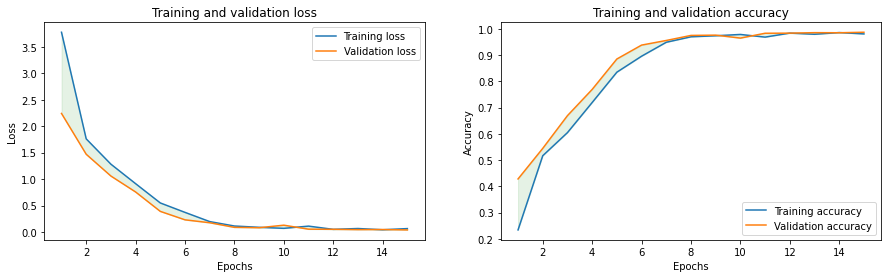

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Inference

In [42]:
def infer_nmt(encoder_model, decoder_model, test_en_seq, en_vsize, fr_vsize):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_fr_seq = sents2sequences(fr_tokenizer, ['sos'], fr_vsize)
    test_en_onehot_seq = to_categorical(test_en_seq, num_classes=en_vsize)
    test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_en_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    fr_text = ''
    for i in range(20):

        dec_out, attention, dec_state = decoder_model.predict([enc_outs, dec_state, test_fr_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_fr_seq = sents2sequences(fr_tokenizer, [fr_index2word[dec_ind]], fr_vsize)
        test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

        attention_weights.append((dec_ind, attention))
        fr_text += fr_index2word[dec_ind] + ' '

    return fr_text, attention_weights

In [54]:
test_en = tr_en_text[3]
# test_en = "the united states is sometimes chilly during december , but it is sometimes freezing in june"
print('English: {}'.format(test_en))

test_en_seq = sents2sequences(en_tokenizer, [test_en], pad_length=en_timesteps)
test_fr, attn_weights = infer_nmt(
    encoder_model=infer_enc_model, decoder_model=infer_dec_model,
    test_en_seq=test_en_seq, en_vsize=en_vsize, fr_vsize=fr_vsize)
print('French: {}'.format(test_fr))


English: california is beautiful during may , and it is wonderful in september .

French: il est merveilleux au mois de mai et il est merveilleux en septembre eos 
